In [26]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import re
from models import *
from plot_utils import *
from presentation_plot_utils import *
from math import ceil
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
plt.rcParams['figure.figsize'] = (10, 6.5)
plt.rcParams['font.size'] = 29
plt.rcParams['font.weight'] = 500
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 29
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 29
plt.rcParams['lines.markersize'] = 11
plt.rcParams['lines.linewidth'] = 4

sns.set_style('ticks')
sns.set_palette('Paired', 10)

In [19]:
rmse_df = pd.read_csv('rmse.csv')
sampling_df = pd.read_csv('../decision-rule/simdex-decision-rule.csv')

simdex_netflix_df = pd.read_csv('timing-results/netflix-simdex-timing.csv')
blocked_mm_netflix_df = pd.read_csv('timing-results/netflix-blocked_mm-timing.csv')

simdex_kdd_df = pd.read_csv('timing-results/kdd-simdex-timing.csv')
blocked_mm_kdd_df = pd.read_csv('timing-results/kdd-blocked_mm-timing.csv')

simdex_r2_df = pd.read_csv('timing-results/r2-simdex-timing.csv')
blocked_mm_r2_df = pd.read_csv('timing-results/r2-blocked_mm-timing.csv')

simdex_lastfm_df = pd.read_csv('timing-results/lastfm-simdex-timing.csv')
blocked_mm_lastfm_df = pd.read_csv('timing-results/lastfm-blocked_mm-timing.csv')

simdex_glove_df = pd.read_csv('timing-results/glove-simdex-timing.csv')
blocked_mm_glove_df = pd.read_csv('timing-results/glove-blocked_mm-timing.csv')

simdex_df = pd.concat([simdex_netflix_df, simdex_kdd_df, simdex_r2_df, simdex_lastfm_df, simdex_glove_df])
lemp_df = pd.read_csv('timing-results/lemp-gold-standard-timing.csv')
naive_df = pd.read_csv('timing-results/naive-gold-standard-timing.csv')
blocked_mm_df = pd.concat([blocked_mm_netflix_df, blocked_mm_kdd_df, blocked_mm_r2_df,blocked_mm_lastfm_df,
                           blocked_mm_glove_df])
both_df = pd.concat([simdex_df, blocked_mm_df])

fexipro_df_all = pd.read_csv('timing-results/fexipro-orig-timing.csv')
fexipro_df = fexipro_df_all.query('alg == "SIR"')
fexipro_si_df = fexipro_df_all.query('alg == "SI"')

fexipro_estimates = pd.read_csv('runtime-estimates/fexipro.csv')
lemp_estimates = pd.read_csv('runtime-estimates/lemp.csv')
simdex_estimates = pd.read_csv('runtime-estimates/simdex.csv')
blocked_mm_esitmates = pd.read_csv('runtime-estimates/blocked_mm.csv')

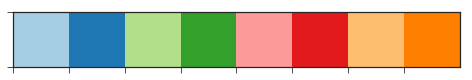

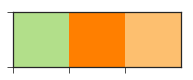

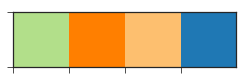

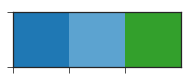

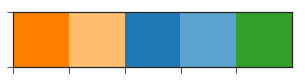

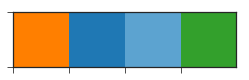

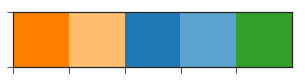

In [44]:
paired_palette = sns.color_palette('Paired', 8)
blue_palette = sns.color_palette('Blues', 10)
green_palette = sns.color_palette('Greens', 10)
line_plots_palette = [paired_palette[1]] + [blue_palette[-5]] + [paired_palette[3]]
f_u_palette = [paired_palette[-1], paired_palette[-2], paired_palette[1], blue_palette[-5], paired_palette[3],]
appetizer_palette = f_u_palette[0:1] + f_u_palette[2:]
rmse_reg_palette = f_u_palette
naive_palette = paired_palette[-2:] + [paired_palette[2]]
blocked_mm_palette = [paired_palette[1]] + naive_palette

# f_u_palette.reverse()
naive_palette.reverse()
blocked_mm_palette.reverse()

sns.palplot(paired_palette)
sns.palplot(naive_palette)
sns.palplot(blocked_mm_palette)
sns.palplot(line_plots_palette)
sns.palplot(f_u_palette)
sns.palplot(appetizer_palette)
sns.palplot(rmse_reg_palette)

Naive
                          model   K  comp_time   algo
152  nomad-Netflix-100-reg-0.05   1   2115.788  Naïve
154  nomad-Netflix-100-reg-0.05   5   2206.256  Naïve
153  nomad-Netflix-100-reg-0.05  10   2266.752  Naïve
155  nomad-Netflix-100-reg-0.05  50   2711.340  Naïve
LEMP
                          model   K  comp_time  algo
202  nomad-Netflix-100-reg-0.05   1    155.375  LEMP
204  nomad-Netflix-100-reg-0.05   5    190.289  LEMP
203  nomad-Netflix-100-reg-0.05  10    209.097  LEMP
205  nomad-Netflix-100-reg-0.05  50    274.598  LEMP
FEXIPRO
                          model   K   comp_time     algo
414  nomad-Netflix-100-reg-0.05   1  346.108701  FEXIPRO
418  nomad-Netflix-100-reg-0.05   5  422.191716  FEXIPRO
416  nomad-Netflix-100-reg-0.05  10  462.814415  FEXIPRO
420  nomad-Netflix-100-reg-0.05  50  607.874498  FEXIPRO
Blocked MM
                          model   K  comp_time        algo
152  nomad-Netflix-100-reg-0.05   1    52.8947  Blocked MM
154  nomad-Netflix-100-reg-0.05 

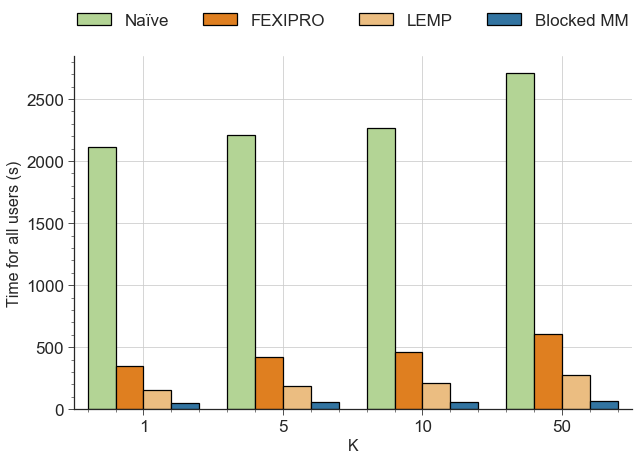

Naive
                       model   K  comp_time   algo
63  nomad-R2-50-reg-0.000001   1    41775.2  Naïve
65  nomad-R2-50-reg-0.000001   5    43700.4  Naïve
64  nomad-R2-50-reg-0.000001  10    43956.8  Naïve
66  nomad-R2-50-reg-0.000001  50    46084.0  Naïve
LEMP
                        model   K  comp_time  algo
293  nomad-R2-50-reg-0.000001   1    277.264  LEMP
295  nomad-R2-50-reg-0.000001   5    343.158  LEMP
294  nomad-R2-50-reg-0.000001  10    375.428  LEMP
296  nomad-R2-50-reg-0.000001  50    575.007  LEMP
FEXIPRO
                        model   K    comp_time     algo
589  nomad-R2-50-reg-0.000001   1   592.976802  FEXIPRO
590  nomad-R2-50-reg-0.000001   1   690.222428  FEXIPRO
597  nomad-R2-50-reg-0.000001   5   742.755404  FEXIPRO
598  nomad-R2-50-reg-0.000001   5   850.223836  FEXIPRO
593  nomad-R2-50-reg-0.000001  10   860.212290  FEXIPRO
594  nomad-R2-50-reg-0.000001  10   976.326031  FEXIPRO
601  nomad-R2-50-reg-0.000001  50  1362.557447  FEXIPRO
602  nomad-R2-50-reg-0.

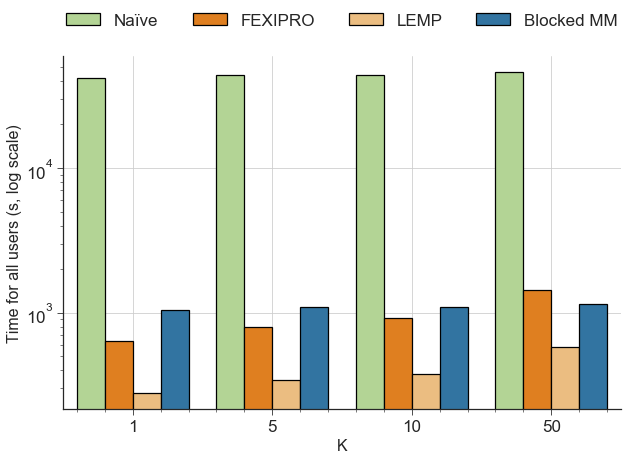

In [79]:
# with sns.color_palette(naive_palette):
#     benchmark_against_naive(lemp_df, fexipro_df, blocked_mm_df,
#             model='nomad-Netflix-100-reg-0.05', K=[1, 5, 10, 50], ncol=3,
#             num_clusters=8, title=False, bbox_to_anchor=(0.5, 1.1))
with sns.color_palette(blocked_mm_palette):
    benchmark_against_blocked_mm(lemp_df, fexipro_df, blocked_mm_df,
            model='nomad-Netflix-100-reg-0.05', K=[1, 5, 10, 50], ncol=4,
            num_clusters=8, title=False, bbox_to_anchor=(0.5, 1.1))
    benchmark_against_blocked_mm(lemp_df, fexipro_df, blocked_mm_df,
            model='nomad-R2-50-reg-0.000001', K=[1, 5, 10, 50], ncol=4,
            num_clusters=8, title=False, bbox_to_anchor=(0.5, 1.1), log=True)

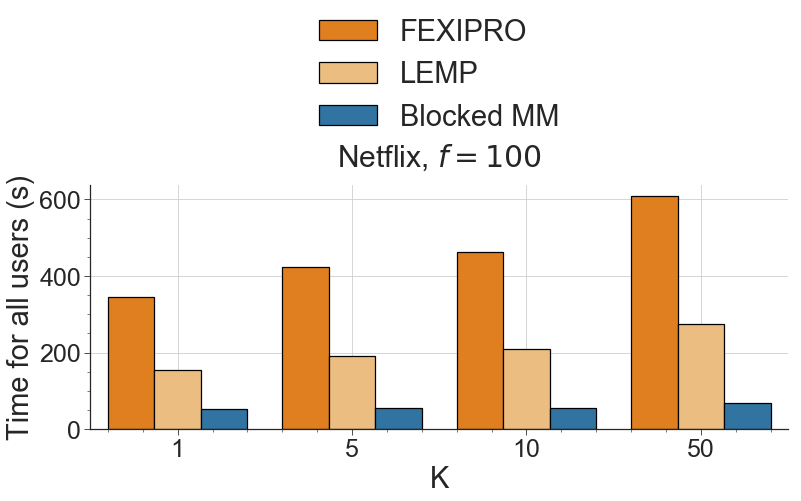

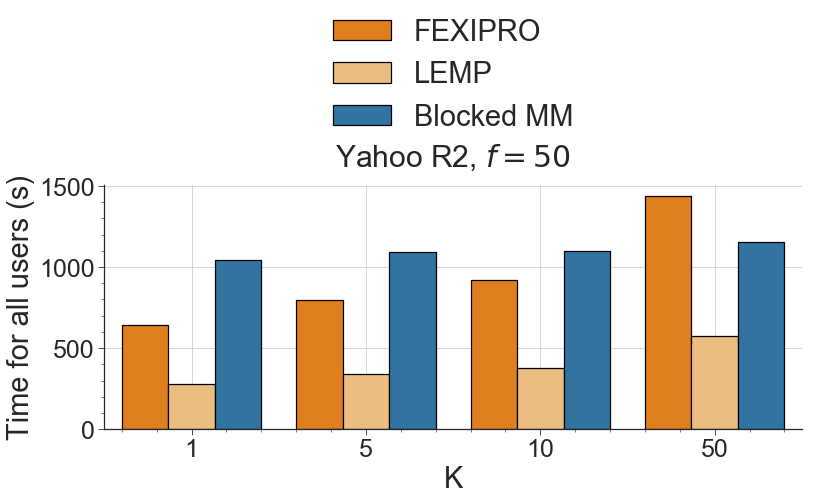

In [5]:
with sns.color_palette(blocked_mm_palette[1:]):
    benchmark_against_blocked_mm(lemp_df, fexipro_df, blocked_mm_df,
            model='nomad-Netflix-100-reg-0.05', include_naive=False, K=[1, 5, 10, 50],
            num_clusters=8, y_title=1.05, figsize=(12.5, 4.5), bbox_to_anchor=(0.5, 1.45))
    benchmark_against_blocked_mm(lemp_df, fexipro_df, blocked_mm_df,
            model='nomad-R2-50-reg-0.000001', include_naive=False, K=[1, 5, 10, 50],
            num_clusters=8, y_title=1.05, figsize=(12.5, 4.5), bbox_to_anchor=(0.5, 1.45))

LEMP
                    model   K  comp_time  algo
127  lemp-paper-Glove-200   1    14130.0  LEMP
130  lemp-paper-Glove-200  50    14325.5  LEMP
Optimus
                    model   K  comp_time                           algo
136  lemp-paper-Glove-200   1   1363.454  Optimus: Blocked MM + Maximus
139  lemp-paper-Glove-200  50   1388.683  Optimus: Blocked MM + Maximus


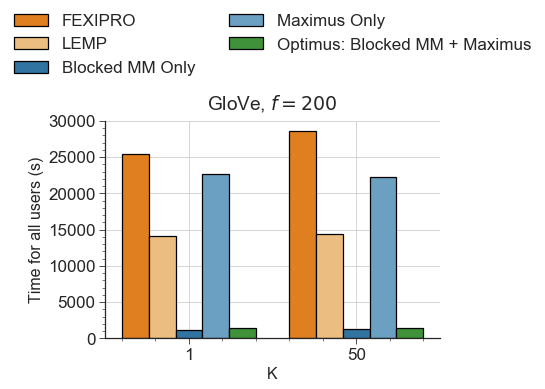

LEMP
                        model   K  comp_time  algo
293  nomad-R2-50-reg-0.000001   1    277.264  LEMP
296  nomad-R2-50-reg-0.000001  50    575.007  LEMP
Optimus
                        model   K  comp_time                           algo
361  nomad-R2-50-reg-0.000001   1  243.74967  Optimus: Blocked MM + Maximus
364  nomad-R2-50-reg-0.000001  50  474.74705  Optimus: Blocked MM + Maximus


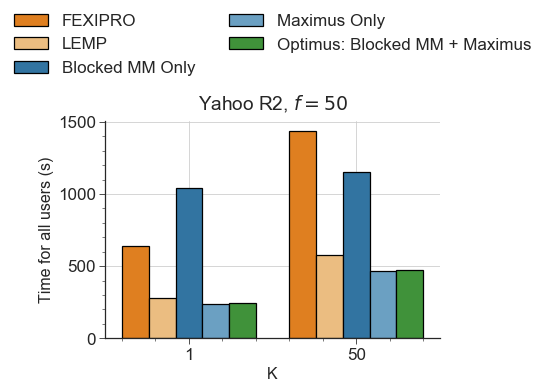

LEMP
                          model   K  comp_time  algo
202  nomad-Netflix-100-reg-0.05   1    155.375  LEMP
205  nomad-Netflix-100-reg-0.05  50    274.598  LEMP
Optimus
                          model   K  comp_time                           algo
248  nomad-Netflix-100-reg-0.05   1   54.34959  Optimus: Blocked MM + Maximus
251  nomad-Netflix-100-reg-0.05  50   69.19704  Optimus: Blocked MM + Maximus


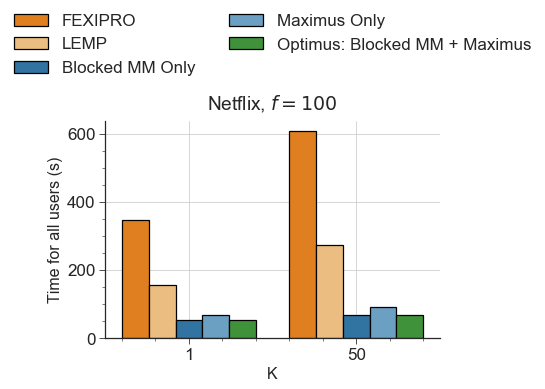

LEMP
                   model   K  comp_time  algo
166  nomad-KDD-100-reg-1   1    6704.68  LEMP
169  nomad-KDD-100-reg-1  50   14859.20  LEMP
Optimus
                   model   K  comp_time                           algo
196  nomad-KDD-100-reg-1   1  4243.0679  Optimus: Blocked MM + Maximus
199  nomad-KDD-100-reg-1  50  4700.0867  Optimus: Blocked MM + Maximus


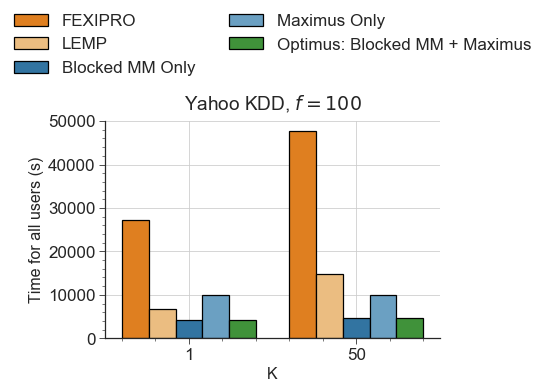

In [71]:
with sns.color_palette(f_u_palette):
    for model in ['lemp-paper-Glove-200', 'nomad-R2-50-reg-0.000001', 'nomad-Netflix-100-reg-0.05',
             'nomad-KDD-100-reg-1']:
        f_u_plot_single(simdex_df, lemp_df, blocked_mm_df, fexipro_df, sampling_df,
                        K=[1, 50], model=model, num_clusters=8, y_title=1.02)

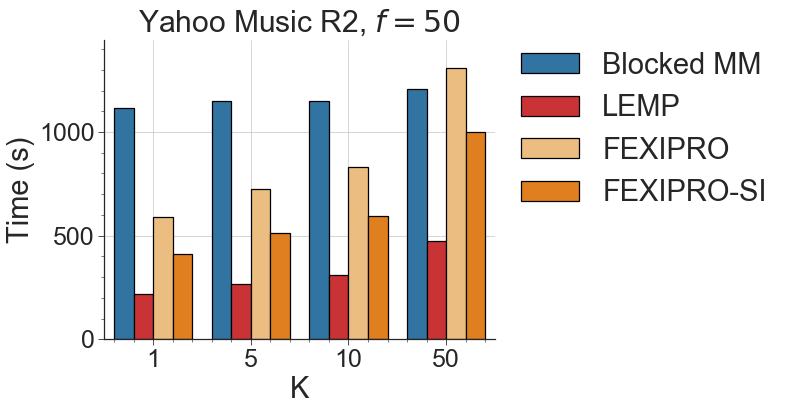

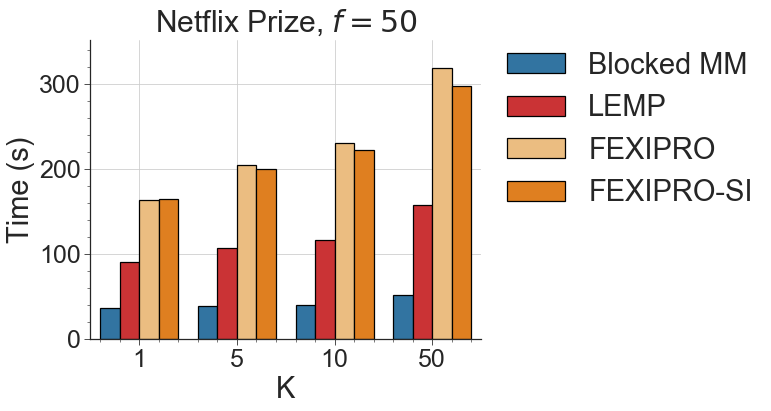

In [7]:
with sns.color_palette(appetizer_palette):
    blocked_mm_lemp_fexipro_plot(blocked_mm_df, lemp_df, fexipro_df, fexipro_si_df,
                             'nomad-R2-50-reg-0.001', y_title=1.01, figsize=(7, 5.5), title=r'Yahoo Music R2, $f=50$')
    blocked_mm_lemp_fexipro_plot(blocked_mm_df, lemp_df, fexipro_df, fexipro_si_df,
                             'nomad-Netflix-50-reg-0.05', y_title=1.01, figsize=(7, 5.5),
                             title=r'Netflix Prize, $f=50$')

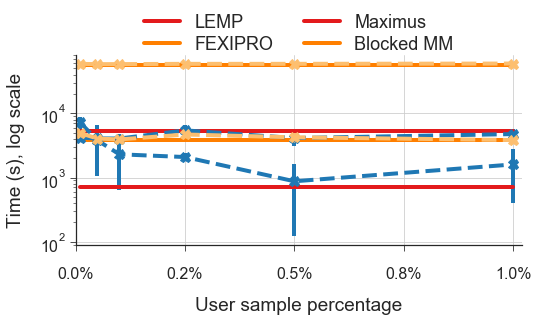

In [10]:
# custom settings for the line plots
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 500
plt.rcParams['axes.titlesize'] = 19
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 19
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 4

with sns.color_palette(appetizer_palette):
    runtime_estimates_plot([
                        'lemp-paper-KDD-50',
#                         'lemp-paper-Netflix-noav-50',
#                         'nomad-KDD-50-reg-1',
#                         'nomad-Netflix-50-reg-0.05',
#                         'nomad-R2-50-reg-0.000001',
                       ], lemp_estimates, lemp_df, fexipro_estimates, fexipro_df_all, simdex_estimates, simdex_df,
                        blocked_mm_esitmates, blocked_mm_df, markerstyle='X',
                      figsize=(8,3.5))

# return to normal
plt.rcParams['font.size'] = 29
plt.rcParams['font.weight'] = 500
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['figure.titlesize'] = 32
plt.rcParams['axes.labelsize'] = 29
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 29
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 4

In [ ]:
# custom settings for the line plots
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 500
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['figure.titlesize'] = 23
plt.rcParams['axes.labelsize'] = 21
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['lines.markersize'] = 12
plt.rcParams['lines.linewidth'] = 3.5

appetizer_models = [
    ('nomad-Netflix-50', NETFLIX_REGS, (-5, 120), r'Netflix, $f=50$'),
    ('nomad-R2-25', R2_REGS, (0, 80), r'Yahoo R2, $f=25$')    
]

all_models = [
    ('nomad-Netflix-50', NETFLIX_REGS, (-5, 135), r'Netflix-NOMAD, $f=50$'),
    ('nomad-Netflix-100', NETFLIX_REGS, (-5, 135), r'Netflix-NOMAD, $f=100$'),
    ('nomad-R2-50', R2_REGS[:-1], (15, 150), r'R2-NOMAD, $f=50$'),
    ('nomad-R2-100', R2_REGS[:-1],(60, 120), r'R2-NOMAD, $f=100$'),
    ('nomad-KDD-10', KDD_REGS, (-24, 135), r'KDD-NOMAD, $f=10$'),
]
for add_simdex in [False]:
    models = all_models if add_simdex else appetizer_models
    _palette = rmse_reg_palette if add_simdex else appetizer_palette
    for model_prefix, regs, xy_text, title_text in models:
        _simdex_df = simdex_df if add_simdex else None
        fname = 'appetizer-' + model_prefix if not add_simdex else None
        with sns.color_palette(_palette):
            rmse_and_reg_plots(blocked_mm_df, lemp_df, rmse_df, model_prefix, regs,
                               simdex_df=_simdex_df, fexipro_df=fexipro_df, fexipro_si_df=fexipro_si_df,
                               fname=fname, figsize=(5.5, 7),
                               bbox_to_anchor=(0,0,1,1.05), title=True, title_text=title_text, 
                               y_title=1.03, annotate=True, xy_text=xy_text,
                               linestyle='-', markerstyle='o',
                               include_legend=False)
            rmse_and_reg_legend(add_simdex, linestyle='-', markerstyle='o')
     
# return to normal
plt.rcParams['font.size'] = 29
plt.rcParams['font.weight'] = 500
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['figure.titlesize'] = 32
plt.rcParams['axes.labelsize'] = 29
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 29
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 4        
sns.set_palette('Paired', 10)


In [ ]:
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['legend.fontsize'] = 21
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 21
num_clusters_vs_runtime(simdex_df, ['lemp-paper-Netflix-noav-50',
                                    'nomad-Netflix-50-reg-0.05',
                                    'nomad-R2-10-reg-0.001',
                                    'nomad-R2-100-reg-0',
                                   ], figsize=(25, 5), y_title=-0.3,
                            bbox_to_anchor=(0,0,1,1.05), min_value=0, max_value=512)
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.fontsize'] = 29
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['axes.labelsize'] = 29

In [ ]:
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['legend.fontsize'] = 21
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 21

# TODO: lemp-paper-Netflix-noav-50 and nomad-R2-50-reg-0.000001 don't have all the clusters
batch_size_vs_runtime(simdex_df, [
                                  'nomad-Netflix-50-reg-0.05',
                                  'lemp-paper-Netflix-noav-50',
                                  'nomad-R2-50-reg-0.000001',
                                  'nomad-R2-100-reg-0',
                                  ], figsize=(25,5), bbox_to_anchor=(0,0,1,1.05), y_title=-0.3)
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.fontsize'] = 29
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['axes.labelsize'] = 29

In [ ]:
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['lines.linewidth'] = 6
with sns.color_palette(f_u_palette):
    point_query_time(['lemp-paper-Netflix-noav-50', 'nomad-Netflix-50-reg-0.05',
                      'nomad-R2-50-reg-0.001', 'nomad-KDD-50-reg-1'],
                     csv_dir='point-query-stats/', figsize=(32, 6.5),
                     sample_fraction=1.0, y_title=-0.38)
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['lines.linewidth'] = 4

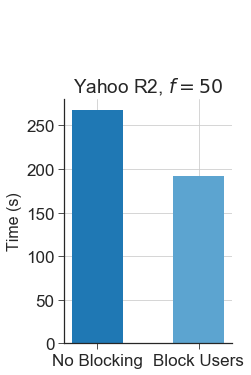

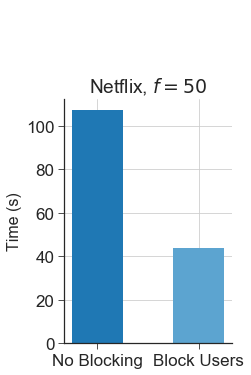

In [69]:
plt.rcParams['font.size'] = 25
plt.rcParams['axes.titlesize'] = 19
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 17
plt.rcParams['legend.fontsize'] = 17
plt.rcParams['lines.markersize'] = 11
plt.rcParams['lines.linewidth'] = 2.50
with sns.color_palette(f_u_palette[-3:-1]):
    factor_analysis(figsize=(3,4.5), model='yahoo-r2-50')
    factor_analysis(figsize=(3,4.5), model='netflix-50')

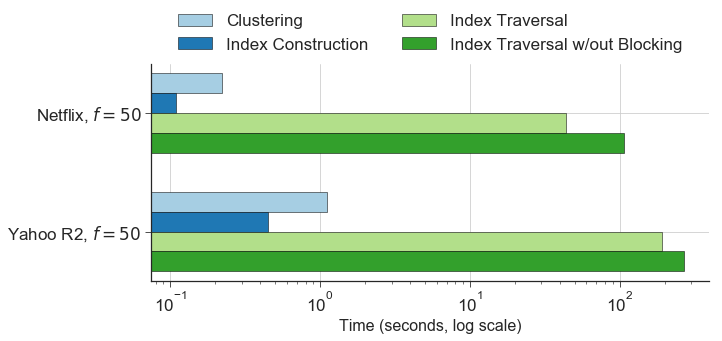

In [38]:
plt.rcParams['font.size'] = 25
plt.rcParams['axes.titlesize'] = 19
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 17
plt.rcParams['legend.fontsize'] = 17
plt.rcParams['lines.markersize'] = 11
plt.rcParams['lines.linewidth'] = 2.50
factor_analysis_poster(figsize=(10, 4))

In [ ]:
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22

lemp_model_df = lemp_df.query('model.str.contains("lemp-paper-Netflix-noav") and K == 1', engine='python')
lemp_data = lemp_model_df[['model', 'num_latent_factors', 'comp_time']]
lemp_data['index_time'] = lemp_model_df['preproc_time'] + lemp_model_df['index_time']
lemp_data['algo'] = 'LEMP'


fexipro_model_df = fexipro_df.query('model.str.contains("lemp-paper-Netflix-noav") and K == 1', engine='python')
fexipro_data = fexipro_model_df[['model', 'num_latent_factors', 'comp_time']]
fexipro_data['index_time'] = fexipro_model_df['preproc_time']
fexipro_data['algo'] = 'FEXIPRO'

data = pd.concat([lemp_data, fexipro_data])
data.replace({"model": LABEL_DICT}, inplace=True)
data.sort_values(by='num_latent_factors', inplace=True)

print((data['comp_time'] - data['index_time']) / data['index_time'])

plt.figure(figsize=(10, 4))
sns.barplot(x='model', y='comp_time', hue='algo', data=data, edgecolor='black')
ax = sns.barplot(x='model', y='index_time', hue='algo', data=data, hatch='\\', edgecolor='black')
ax.legend_.remove()

ax.set_yscale('log')
ax.set_xlabel('Model')
ax.set_ylabel('Time (s), log scale')
xticklabels = [label.get_text().replace('-DSGD', '',) for label in ax1.get_xticklabels()]
ax.set_xticklabels(xticklabels)

lemp_legend = plt.Rectangle((0,0),1,1, edgecolor='none')
fexipro_legend = plt.Rectangle((0,0),1,1, fc=palette[1], edgecolor='none')
index_time_legend = plt.Rectangle((0,0),1,1, fill=False, hatch='\\')

legend = ax.legend([index_time_legend, lemp_legend, fexipro_legend],
                    ['Index Construction', 'LEMP', 'FEXIPRO'],
                    loc='bottom right',                       
                    ncol=1,
                    handletextpad=0.5,
                    columnspacing=1.25,
                    bbox_to_anchor=(0.48, 0.58),
                    fontsize=21)

sns.despine()

save_figure('index-construction', (legend,))

plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

In [ ]:
df = pd.read_csv('user-stats.csv')
fig, (ax0, ax1) = plt.subplots(2, 1)
sns.boxplot(x=df["theta_b"], y=df["num_items_visited"], ax=ax0)
ax1.scatter(x=df['theta_uc'], y=df['num_items_visited'], s=5)
sns.despine()
df.groupby('cluster_id').agg('median').sort_values(by='theta_b')